<a href="https://colab.research.google.com/github/xiekg2020/DL_test/blob/main/4_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import tensorflow as tf
!pip install d2l
from d2l import tensorflow as d2l

     |████████████████████████████████| 81kB 7.5MB/s 


In [2]:
max_degree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = np.zeros(max_degree)  # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# Convert from NumPy ndarrays to tensors
true_w, features, poly_features, labels = [
    tf.constant(x, dtype=tf.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[0.27918604],
        [0.484425  ]], dtype=float32)>,
 <tf.Tensor: shape=(2, 20), dtype=float32, numpy=
 array([[1.0000000e+00, 2.7918604e-01, 3.8972422e-02, 3.6268518e-03,
         2.5314160e-04, 1.4134720e-05, 6.5770274e-07, 2.6231630e-08,
         9.1543811e-10, 2.8397503e-11, 7.9281866e-13, 2.0122172e-14,
         4.6815246e-16, 1.0053971e-17, 2.0049488e-19, 3.7316912e-21,
         6.5114756e-23, 1.0693606e-24, 1.6586143e-26, 2.4371680e-28],
        [1.0000000e+00, 4.8442501e-01, 1.1733380e-01, 1.8946474e-02,
         2.2945367e-03, 2.2230619e-04, 1.7948447e-05, 1.2420966e-06,
         7.5212832e-08, 4.0483310e-09, 1.9611128e-10, 8.6364735e-12,
         3.4864364e-13, 1.2991669e-14, 4.4953494e-16, 1.4517733e-17,
         4.3954703e-19, 1.2525152e-20, 3.3708317e-22, 8.5942901e-24]],
       dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([5.27936  , 5.3204174], dtype=float32)>)

In [4]:
def evaluate_loss(net, data_iter, loss):
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        l = loss(net(X), y)
        metric.add(tf.reduce_sum(l), tf.size(l).numpy())
    return metric[0] / metric[1]

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = tf.losses.MeanSquaredError()
    input_shape = train_features.shape[-1]
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Dense(1, use_bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    test_iter = d2l.load_array((test_features, test_labels), batch_size,
                               is_train=False)
    trainer = tf.keras.optimizers.SGD(learning_rate=.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net.get_weights()[0].T)

weight: [[ 4.9886713  1.2042372 -3.398948   5.58187  ]]


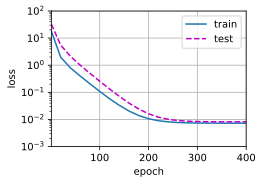

In [7]:
# Pick the first four dimensions, i.e., 1, x, x^2/2!, x^3/3! from the
# polynomial features
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])